Background: Dogecoin is a memecoin because it was created as a joke but has attracted a lot of attention when it ranked top 10 with ~33B USD market cap

Context: In Dogecoin's perspective, how does Elon Musk tweeting about Dogecoin influence the Google search engagement and crypto market value

Hypotheses

1. Elon Musk tweeting about Dogecoin heavily impacts the cryto price
    - Analyze the reaction of Dogecoin price 10 mins after Elon Musk tweeted about it
2. Elon Musk tweeting about Dogecoin heavily impacts the Google search engagement
    - Alanlyze possible delayed effect of Elon Musk's tweet on Dogecoin' Google search engagement

### Import Packages

In [2]:
import pandas as pd
import ccxt
from datetime import datetime,timedelta
import numpy as np
from pytrends.request import TrendReq
from dateutil import parser
import matplotlib.pyplot as plt 
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Read Dogecoin Tweets and Cyrpto Price to Merge

In [3]:
tweets_df = pd.read_csv('data/dogecoin_tweets.csv')
tweets_df['timestamp'] = pd.to_datetime(tweets_df['timestamp'])

dogecoin_price_df = pd.read_csv('data/price_clean.csv')

dogecoin_price_df['timestamp'] = pd.to_datetime(dogecoin_price_df['timestamp'], unit='ms')
dogecoin_price_df.sort_values(by='timestamp', inplace=True)
merge_df = pd.merge(left=dogecoin_price_df, right=tweets_df, how='left', on='timestamp')
merge_df.head()

,timestamp,open,high,low,close,volume,tweet_content,retweet_count,quote_count,like_count
0,2020-12-20 08:30:00,0.003920,0.003930,0.003920,0.003922,1487104.0,NaN,NaN,NaN,NaN
1,2020-12-20 08:31:00,0.003925,0.003925,0.003922,0.003922,181327.0,NaN,NaN,NaN,NaN
2,2020-12-20 08:32:00,0.003922,0.003922,0.003922,0.003922,0.0,NaN,NaN,NaN,NaN
3,2020-12-20 08:33:00,0.003922,0.003922,0.003922,0.003922,0.0,NaN,NaN,NaN,NaN
4,2020-12-20 08:34:00,0.003922,0.003923,0.003922,0.003922,167833.0,NaN,NaN,NaN,NaN


In [4]:
# Proprocess the price data
# select the tweet_content col that is not null
twitter_index = merge_df[merge_df['tweet_content'].notnull()].index
merge_df.loc[twitter_index, 'tweet'] =True # If it is the time that Musk tweeted


# Calculate the change in price
merge_df['price_change'] = (merge_df['close']-merge_df['open'])/merge_df['open']



In [5]:
# Identify the timestamp with gaps
timestamp_gap_index = []
timestamp_col = merge_df["timestamp"]
for i, timestamp in enumerate(timestamp_col):
    if (i!=0) and abs(parser.parse(str(timestamp))-parser.parse(str(timestamp_col[i-1])))>timedelta(minutes=1):
            timestamp_gap_index.append(i)
merge_df.loc[timestamp_gap_index,'time_gap']=True
merge_df.loc[timestamp_gap_index,["price_change"]]=np.nan # Fill the gap with nan
timestamp_gap_index


[120,
 292,
 412,
 532,
 652,
 772,
 892,
 1012,
 1132,
 1263,
 1383,
 1503,
 1623,
 1743,
 1863,
 1983,
 2103,
 2263,
 2424]

In [6]:
# Select the index between two time_gap which before the tweet time
price_change_before_twitter_list = []
price_change_after_twitter_list = []
volume_before_twitter_list = []
volume_after_twitter_list = []
volatility_before_twitter_list = []
volatility_after_twitter_list = []
for count,index in enumerate(timestamp_gap_index):
    if count!=0:
        dfm_temp = merge_df.loc[timestamp_gap_index[count-1]:index-1]
    else:
        dfm_temp = merge_df.loc[0:index-1]
    # Analysis
    # Find the first tweet index 
    first_tweet_index = dfm_temp[dfm_temp['tweet']==True].index[0]
    # Find the last tweet index
    last_tweet_index = dfm_temp[dfm_temp['tweet']==True].index[-1]
    # Find the first price change before the first tweet
    price_change_before_twitter = list(dfm_temp.loc[dfm_temp.index[0]:first_tweet_index]['price_change'])
    price_change_before_twitter_list.extend(price_change_before_twitter)
    # Find the last price change after the last tweet
    price_change_after_twitter = list(dfm_temp.loc[last_tweet_index:]['price_change'])
    price_change_after_twitter_list.extend(price_change_after_twitter)
    # Find the first volume before the first tweet
    volume_before_twitter_list.extend(list(dfm_temp.loc[dfm_temp.index[0]:first_tweet_index]['volume']))
    # Find the last volume after the last tweet
    volume_after_twitter_list.extend(list(dfm_temp.loc[last_tweet_index:]['volume']))
    # Find the first volatility before the first tweet
    volatility_before_twitter_list.append(dfm_temp.loc[dfm_temp.index[0]:first_tweet_index]['price_change'].std())
    # Find the last volatility after the last tweet
    volatility_after_twitter_list.append(dfm_temp.loc[last_tweet_index:]['price_change'].std()) 
    

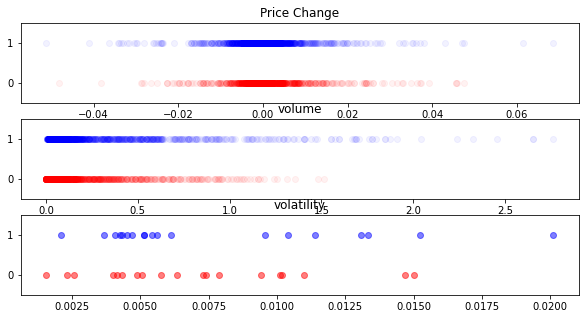

In [7]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

# draw the scatter plot of price change
ax1.set_title('Price Change')
ax1.set_ylim(-0.5,1.5,1)
ax1.scatter(price_change_before_twitter_list, [0]*len(price_change_before_twitter_list), marker='o', color='r', alpha=0.05)
ax1.scatter(price_change_after_twitter_list, [1]*len(price_change_after_twitter_list), marker='o', color='b', alpha=0.05)

ax2.set_title('volume')
ax2.set_ylim(-0.5,1.5,1)
ax2.scatter(volume_before_twitter_list, [0]*len(volume_before_twitter_list), marker='o', color='r', alpha=0.05)
ax2.scatter(volume_after_twitter_list, [1]*len(volume_after_twitter_list), marker='o', color='b', alpha=0.05)

ax3.set_title('volatility')
ax3.set_ylim(-0.5,1.5,1)
ax3.scatter(volatility_before_twitter_list, [0]*len(volatility_before_twitter_list), marker='o', color='r', alpha=0.5)
ax3.scatter(volatility_after_twitter_list, [1]*len(volatility_after_twitter_list), marker='o', color='b', alpha=0.5)


In [8]:
# Hypothesis:
# There is a significant change between the price change before and after the tweet
# There is a significant change between the volume before and after the tweet
# There is a significant change between the volatility before and after the tweet


# X =np.array([0]*len(price_change_before_twitter_list)+[1]*len(price_change_after_twitter_list)).astype("int")
# Y = np.array(price_change_before_twitter_list+price_change_after_twitter_list).astype('float64')
# dfm_price_change = pd.DataFrame({'X':X, 'Y':Y})
# dfm_price_change.dropna(inplace=True)
# X = dfm_price_change["X"]
# Y = dfm_price_change["Y"]
# # print(X,Y)
# # X = sm.add_constant(X)
# lm = sm.OLS(Y,X).fit()
# print (lm.summary()) 

# X=np.array([0]*len(volume_before_twitter_list)+[1]*len(volume_after_twitter_list)).astype("int")
# Y = np.array(volume_before_twitter_list+volume_after_twitter_list).astype('float64')
# dfm_volume = pd.DataFrame({'X':X, 'Y':Y})
# dfm_volume.dropna(inplace=True)
# X = dfm_volume["X"]
# Y = dfm_volume["Y"]
# # print(X,Y)
# # X = sm.add_constant(X)
# lm = sm.OLS(Y,X).fit()
# print (lm.summary())

X=np.array([0]*len(volatility_before_twitter_list)+[1]*len(volatility_after_twitter_list)).astype("int")
Y = np.array(volatility_before_twitter_list+volatility_after_twitter_list).astype('float64')
dfm_volatility = pd.DataFrame({'X':X, 'Y':Y})
dfm_volatility.dropna(inplace=True)
X = dfm_volatility["X"]
Y = dfm_volatility["Y"]
# print(X,Y)
# X = sm.add_constant(X)
lm = sm.OLS(Y,X).fit()
print (lm.summary())


                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.414
Model:                            OLS   Adj. R-squared (uncentered):              0.398
Method:                 Least Squares   F-statistic:                              26.10
Date:                Fri, 12 Nov 2021   Prob (F-statistic):                    1.01e-05
Time:                        21:24:05   Log-Likelihood:                          137.05
No. Observations:                  38   AIC:                                     -272.1
Df Residuals:                      37   BIC:                                     -270.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Google trends

In [9]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["doge"],timeframe='2020-12-01 2021-07-31')
trends = pytrend.interest_over_time()
trendsdf_part1 = pd.DataFrame(data = {'date': trends.index.tolist(),
                                'search': trends["doge"].tolist()})
pytrend.build_payload(kw_list = ["doge"],timeframe='2021-08-01 2021-12-31')
trends = pytrend.interest_over_time()
trendsdf_part2 = pd.DataFrame(data = {'date': trends.index.tolist(),
                                'search': trends["doge"].tolist()})
trendsdf = trendsdf_part1.append(trendsdf_part2)
trendsdf['date'] = pd.to_datetime(trendsdf['date']).dt.date
tweets_df["timestamp"] = pd.to_datetime(tweets_df["timestamp"]).dt.date
merged_dfm = pd.merge(left=tweets_df, right=trendsdf, how='right', left_on='timestamp',right_on='date')
merged_dfm.sort_values(by='date', inplace=True)


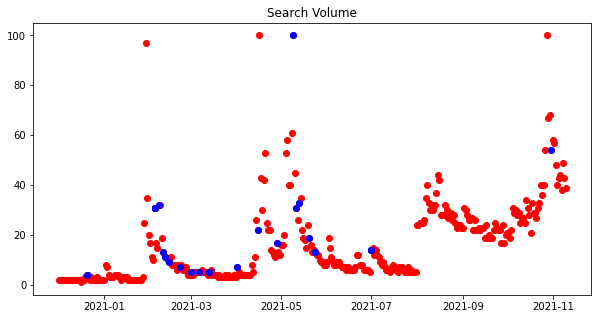

In [10]:
# plt search scatter 
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_title('Search Volume')
plt.scatter(merged_dfm["date"],merged_dfm["search"], marker='o', color='r')
plt.scatter(merged_dfm.dropna()["date"],merged_dfm.dropna()["search"], marker='o', color='b')

In [12]:
# Hypothesis:
# There is a significant change between the search change with or without the tweet
merged_dfm
merged_dfm["with_tweet"] = merged_dfm["tweet_content"].isna()
merged_dfm["with_tweet"] = merged_dfm["with_tweet"].apply(lambda x: 0 if x else 1)

X=np.array([0]*len(volatility_before_twitter_list)+[1]*len(volatility_after_twitter_list)).astype("int")
Y = np.array(volatility_before_twitter_list+volatility_after_twitter_list).astype('float64')
dfm_volatility = pd.DataFrame({'X':X, 'Y':Y})
dfm_volatility.dropna(inplace=True)
X = dfm_volatility["X"]
Y = dfm_volatility["Y"]
# print(X,Y)
X = sm.add_constant(X)
lm = sm.OLS(Y,X).fit()
print (lm.summary())


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.2782
Date:                Fri, 12 Nov 2021   Prob (F-statistic):              0.601
Time:                        21:24:28   Log-Likelihood:                 153.35
No. Observations:                  38   AIC:                            -302.7
Df Residuals:                      36   BIC:                            -299.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0070      0.001      6.993      0.0

In [16]:
Y_with_twitter = merged_dfm[merged_dfm["with_tweet"]==1]["search"]
X_with_twitter  = merged_dfm[merged_dfm["with_tweet"]==1]["with_tweet"]
Y_without_twitter = merged_dfm[merged_dfm["with_tweet"]==0]["search"]
X_without_twitter  = merged_dfm[merged_dfm["with_tweet"]==0]["with_tweet"]
Y = pd.concat([Y_with_twitter,Y_without_twitter])
X = pd.concat([X_with_twitter,X_without_twitter])
X = sm.add_constant(X)
lm = sm.OLS(Y,X).fit()
print(Y)
print (lm.summary())

19       4
67      31
65      31
66      31
70      32
73      13
74      11
77       9
84       7
92       5
97       5
104      5
105      5
106      5
125      7
139     22
152     17
163    100
165     31
167     33
174     19
178     13
179     13
217     14
218     14
340     54
0        2
1        2
2        2
3        2
4        2
5        2
6        2
7        2
8        2
9        2
10       2
11       2
12       2
13       2
14       2
15       1
16       2
17       2
18       3
20       4
21       2
22       3
23       2
24       2
25       2
26       3
27       2
28       2
29       2
30       2
31       2
32       8
33       7
34       4
35       3
36       3
37       3
38       4
39       4
40       4
41       3
42       2
43       3
44       3
45       3
46       3
47       2
48       2
49       2
50       2
51       2
52       2
53       2
54       2
55       2
56       2
57       3
58      25
59      97
60      35
61      20
62      17
63      11
64      10
68      17

In [ ]:
merged_dfm["with_tweet"] = merged_dfm["tweet_content"].isna()
merged_dfm["with_tweet"] = merged_dfm["with_tweet"].apply(lambda x: 0 if x else 1)

X=np.array([0]*len(volatility_before_twitter_list)+[1]*len(volatility_after_twitter_list)).astype("int")
Y = np.array(volatility_before_twitter_list+volatility_after_twitter_list).astype('float64')
dfm_volatility = pd.DataFrame({'X':X, 'Y':Y})
dfm_volatility.dropna(inplace=True)
X = dfm_volatility["X"]
Y = dfm_volatility["Y"]
# print(X,Y)
# X = sm.add_constant(X)
lm = sm.OLS(Y,X).fit()
print (lm.summary())